In [30]:
import math

import numpy as np
from matplotlib import pyplot as plt

import cv2
from scipy.signal import argrelextrema
from scipy.spatial import ConvexHull
from skimage import measure, draw

import mbb

In [58]:
#run edge detection
def PolyArea2D(pts):
    lines = np.hstack([pts,np.roll(pts,-1,axis=0)])
    area = 0.5*abs(sum(x1*y2-x2*y1 for x1,y1,x2,y2 in lines))
    return area

def find_edges(img_data):
    """
    Find edge of hail using radial of imagery data
    Applied a simple 2nd derivate check and difference checl
    """
    #calculc local min indices
    local_min_idx_list  = argrelextrema(img_data, np.less)[0]
    #calc minimum value
    min_value = np.min(img_data)
    #difference from centroid data value
    img_diff = img_data[0] - img_data
    #calc local gradient
    local_grad       = np.append([0], img_data[:-1]-img_data[1:])
    
    #init loop
    prev_value = 0
    out_idx = 0
    #compare i gradient with i-1 gradient and difference from centroid
    for i, value in enumerate(local_grad):
        if value<prev_value*0.75 and i>1 and img_diff[i]>50:
            #offset back by 1
            out_idx = i-1
            break
        else:
            prev_value = value
        
    return out_idx


def worker(image_ffn, cx_list, cy_list, idx_list, refine_centroid, save_data):
    
    #init output dictionary
    data_dict = {}

    #init stats
    hail_major_axis = []
    hail_minor_axis = []
    hail_area = []

    #transform into hsv colorspace
    img_data = cv2.imread(image_ffn)
    img_data_hls = cv2.cvtColor(img_data, cv2.COLOR_BGR2HLS)


    #init dict
    region_dict = {'region_idx':[],
                    'centroid_list':[], 'new_centroid_list':[],
                    'line_points':[], 'edge_idx_list':[],
                    'line_data':[], 'boundary_points':[],
                    'outlier_mask':[], 'hull_points':[],
                    'corner_points':[],
                    'hail_maj':[], 'hail_min':[], 'hail_area':[]}

    for region_idx in idx_list:


        cx = int(cx_list[region_idx])
        cy = int(cy_list[region_idx])

        #skip if in padding region
        if cx < 50 or cx > 550 or cy < 50 or cy > 550:
            continue

        #append region index
        region_dict['region_idx'].append(region_idx)

        ###########################################################
        # Step 1, refine centroid using centroid of pixels with a
        # luminosity of >200 within a bounding box of radius 4 (1.5cm)
        ###########################################################
        #
        if refine_centroid:
            radius_px     = 4
            #subset using radius
            subset_lum    = img_data_hls[cy-radius_px:cy+radius_px+1, cx-radius_px:cx+radius_px+1 , 1]
            masked_subset = subset_lum > 200
            #run labelling
            label_subset   = measure.label(masked_subset)
            region_subset  = measure.regionprops(label_subset)
            #for first label region
            for next_region in region_subset:
                first_region = next_region
                break
            centroid = first_region.centroid
            #calculate centroid
            new_cx = int(centroid[1])-radius_px+cx
            new_cy = int(centroid[0])-radius_px+cy
            #save centroids
        else:
            new_cx = cx
            new_cy = cy
            region_dict['centroid_list'].append([cx, cy]) 
            region_dict['new_centroid_list'].append([new_cx, new_cy])

        ###########################################################
        # Step 2: find edges
        ###########################################################
        #
        #configuration
        extract_range   = 16 #pixels
        azimuth_spacing = 30 #degrees
        #init azimuth list
        azimuth_list    = np.arange(0,360,azimuth_spacing)
        #init
        line_points     = []
        edge_idx_list   = []
        line_data       = []
        boundary_points = []
        dist_data       = []
        #for each azimuth
        for azi in azimuth_list:
            # create indicies for lines from centroid along search azimuth rays
            end_x    = int(new_cx + extract_range*math.cos(math.radians(azi)))
            end_y    = int(new_cy + extract_range*math.sin(math.radians(azi)))
            line_y, line_x = draw.line(new_cy, new_cx, end_y, end_x)
#             line_x   = np.linspace(new_cx, end_x, extract_range).astype(np.int)
#             line_y   = np.linspace(new_cy, end_y, extract_range).astype(np.int)
            # extract data along 
            data = img_data_hls[line_y, line_x, 1].astype(int)
            #run index search function
            edge_idx = find_edges(data)
            dist     = np.sqrt((new_cx-line_x[edge_idx])**2 + (new_cy-line_y[edge_idx])**2)
            boundary_points.append([line_x[edge_idx], line_y[edge_idx]])
            #store
            line_points.append([line_x, line_y])
            edge_idx_list.append(edge_idx)
            line_data.append(data)
            dist_data.append(dist)
        #store into dict
        region_dict['line_points'].append(line_points) 
        region_dict['edge_idx_list'].append(edge_idx_list)
        region_dict['line_data'].append(line_data)
        region_dict['boundary_points'].append(boundary_points)

        ###########################################################
        # Step 3: find outlier edge points
        ###########################################################

        #init
        dist_array  = np.array(dist_data).astype(float)
        dist_median = np.median(dist_array)
        dist_std    = np.std(dist_array)
        #calculate x,y for median distance
        end_x_median = new_cx + dist_median*np.cos(np.radians(azimuth_list))
        end_y_median = new_cy + dist_median*np.sin(np.radians(azimuth_list))
        #find outliers
        factor = 0.5
        outlier_mask = np.logical_or(dist_array<(dist_median-(dist_median*factor)), dist_array>(dist_median+(dist_median*factor)))
        #mask boundary to remove outliers
        region_dict['outlier_mask'].append(outlier_mask)
        #update outliers with median x,y values for that radial
        boundary_points_array = np.array(boundary_points)
        for idx in np.where(outlier_mask)[0]:
            boundary_points_array[idx] = [end_x_median[idx], end_y_median[idx]]

        ###########################################################
        # Step 4: take convex hull and bounding box
        ###########################################################

        #convert boundary points to polygon using convexhull
        try:
            hull = ConvexHull(boundary_points_array)
        except:
            print('failed on convexhull')
            continue
        #extract vertex list
        vertex_idx_list = hull.vertices #always in clockwise order
        #append first vertex to close polygon
        vertex_idx_list = np.append(vertex_idx_list,vertex_idx_list[0])
        #use vertex list to extract points
        hull_points = boundary_points_array[vertex_idx_list,:]
        #compute stats
        bounding_box = mbb.MinimumBoundingBox(hull_points)
        corner_points = list(bounding_box.corner_points)
        #save
        region_dict['hull_points'].append(hull_points)
        region_dict['corner_points'].append(corner_points)

        ###########################################################
        # Step 5: Genreate stats
        ###########################################################

        len_parallel   = bounding_box.length_parallel
        len_orthogonal = bounding_box.length_orthogonal
        poly_area      = PolyArea2D(hull_points)
        #work out maj/min axis length
        if len_parallel>len_orthogonal:
            maj_axis, min_axis = len_parallel, len_orthogonal
        else:
            maj_axis, min_axis = len_orthogonal, len_parallel
        #save
        region_dict['hail_maj'].append(maj_axis)
        region_dict['hail_min'].append(min_axis)
        region_dict['hail_area'].append(poly_area)

            
    if save_data:
        data_ffn = out_data_path + '/' + image_fn[:-4] + '.csv'
        csv_data = np.column_stack((region_dict['hail_maj'], region_dict['hail_min'], region_dict['hail_area']))
        np.savetxt(data_ffn, csv_data, delimiter=",", fmt='%5.1f')
        
    print('finished processing', str(len(region_dict['hail_area'])), 'hail stones') 

    return img_data, region_dict

In [59]:
image_ffn = '/data/hailpixel_20200119/testing_subset/0328.png'
detection_ffn = 'test-detection.npz'

out = np.load(detection_ffn)
hail_cx = out['hail_cx']
hail_cy = out['hail_cy']
hail_idx = out['hail_idx']

img_data, region_dict = worker(image_ffn, hail_cx, hail_cy, hail_idx, refine_centroid=False, save_data=False)

finished processing 546 hail stones


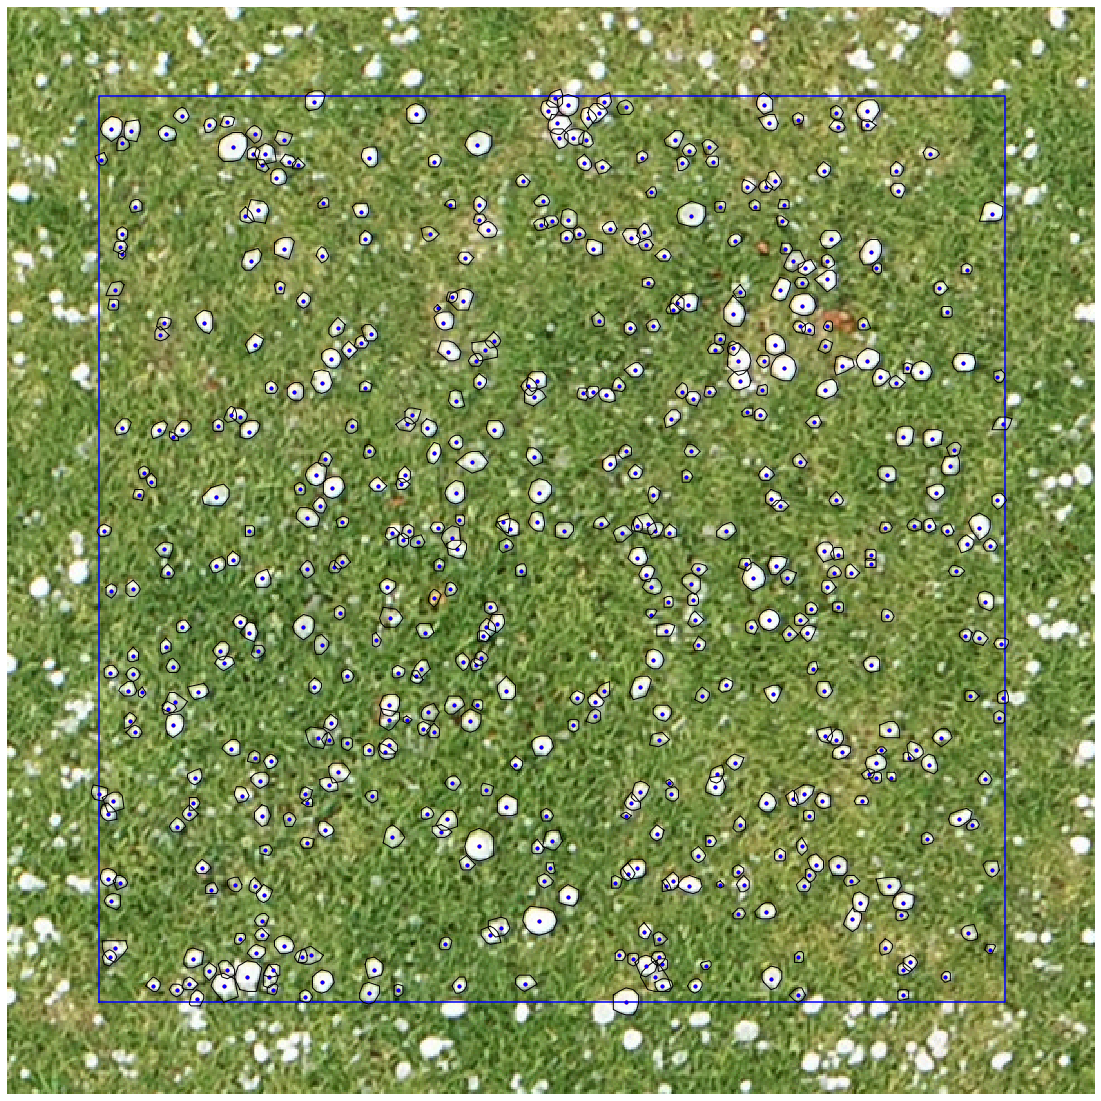

In [60]:
#plotting all

def plot_global(img_data, image_fn, region_dict, save_flag):
    
    """
    plot image with detection and edge information
    """
    
    #plot rgb image with padding box
    fig = plt.figure(facecolor='white',figsize=[20, 20])
    plt.plot([50,50,550,550,50],[50,550,550,50,50],'b-')
    plt.imshow(img_data[:,:,::-1]) #invert colours # RGB-> BGR
    plt.gca().invert_yaxis()
    plt.axis('off')

    #for every region
    for i, region_idx in enumerate(region_dict['region_idx']):
        
        #plot rcnn centroid
        [cx, cy] = region_dict['centroid_list'][i]
        plt.plot(cx, cy, 'r.')

        #plot adjusted centroid
        [new_cx, new_cy] = region_dict['new_centroid_list'][i]
        plt.plot(new_cx,new_cy,'b.')   
        
        #plot index
        #plt.text(new_cx+0.5, new_cy+0.5, str(region_dict['region_idx'][i]))
        
        #plot cenvex hull
        try:
            hull_points = region_dict['hull_points'][i]
            
            #plt.plot(new_cx,new_cy+2,'ko', markersize=15, markerfacecolor='none', markeredgewidth=2)
            plt.plot(hull_points[:,0],hull_points[:,1],'k-', linewidth=1.0)
        except:
            print('missing hull info for plotting')
#     #plot bounding box
#     corner_points = region_dict['corner_points'][i]
#     corner_points_x = [corner_points[0][0], corner_points[1][0], corner_points[2][0], corner_points[3][0], corner_points[0][0]]
#     corner_points_y = [corner_points[0][1], corner_points[1][1], corner_points[2][1], corner_points[3][1], corner_points[0][1]]
#     plt.plot(corner_points_x, corner_points_y, 'w-')
    if save_flag:
        img_ffn = out_image_path + '/' + image_fn
        plt.savefig(img_ffn, dpi=75)
        plt.close()
        

#code to run within cell
plot_global(img_data, image_ffn, region_dict, False)

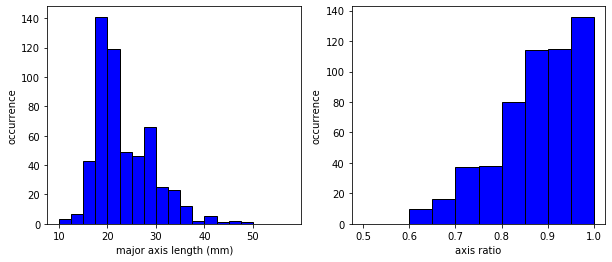

In [66]:
#plot distributions
def plot_stats(hail_maj, hail_min):
    pixel_scaling = 2.6 #mm/pixel
    
    #apply scaling
    hail_maj = hail_maj*pixel_scaling
    hail_min = hail_min*pixel_scaling
    
    # matplotlib histogram
    fig = plt.figure(facecolor='white',figsize=[10, 4])

    plt.subplot(1, 2, 1)
    plt.hist(hail_maj, color = 'blue', edgecolor = 'black', bins=np.arange(10,60,2.5))
    plt.xlabel('major axis length (mm)')
    plt.ylabel('occurrence')

    plt.subplot(1, 2, 2)
    plt.hist(hail_min/hail_maj, color = 'blue', edgecolor = 'black', bins=np.arange(0.5,1.05,0.05))
    plt.xlabel('axis ratio')
    plt.ylabel('occurrence')


hail_major_axis_array = np.array(region_dict['hail_maj'])
hail_minor_axis_array = np.array(region_dict['hail_min'])

plot_stats(hail_major_axis_array, hail_minor_axis_array)